read image width=707, height=1000


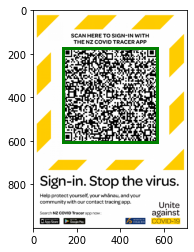

Runtime: 41.455974817276 seconds


In [23]:
import math
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from time import time # used to display program's runtime

import imageIO.png

class Queue:
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items == []

    def enqueue(self, item):
        self.items.insert(0,item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

def createInitializedGreyscalePixelArray(image_width, image_height, initValue = 0):

    new_array = [[initValue for x in range(image_width)] for y in range(image_height)]
    return new_array


# this function reads an RGB color png file and returns width, height, as well as pixel arrays for r,g,b
def readRGBImageToSeparatePixelArrays(input_filename):

    image_reader = imageIO.png.Reader(filename=input_filename)
    # png reader gives us width and height, as well as RGB data in image_rows (a list of rows of RGB triplets)
    (image_width, image_height, rgb_image_rows, rgb_image_info) = image_reader.read()

    print("read image width={}, height={}".format(image_width, image_height))

    # our pixel arrays are lists of lists, where each inner list stores one row of greyscale pixels
    pixel_array_r = []
    pixel_array_g = []
    pixel_array_b = []

    for row in rgb_image_rows:
        pixel_row_r = []
        pixel_row_g = []
        pixel_row_b = []
        r = 0
        g = 0
        b = 0
        for elem in range(len(row)):
            # RGB triplets are stored consecutively in image_rows
            if elem % 3 == 0:
                r = row[elem]
            elif elem % 3 == 1:
                g = row[elem]
            else:
                b = row[elem]
                pixel_row_r.append(r)
                pixel_row_g.append(g)
                pixel_row_b.append(b)

        pixel_array_r.append(pixel_row_r)
        pixel_array_g.append(pixel_row_g)
        pixel_array_b.append(pixel_row_b)

    return (image_width, image_height, pixel_array_r, pixel_array_g, pixel_array_b)

"""
FROM CODERUNNER - CONVERTING INTO GREYSCALE PIXEL ARRAY
"""
def computeRGBToGreyscale(pixel_array_r, pixel_array_g, pixel_array_b, image_width, image_height):
    
    greyscale_pixel_array = createInitializedGreyscalePixelArray(image_width, image_height)

    # greyscale intensity (g) =0.299*r+0.587*g+0.114*b 
    for row in range(image_height):
        for col in range(image_width):
            num = (0.299*pixel_array_r[row][col]) + (0.587*pixel_array_g[row][col]) + (0.114*pixel_array_b[row][col])
            greyscale_pixel_array[row][col] = int(round(num))

    return greyscale_pixel_array

"""
FROM CODERUNNER - SCALING THE GREYSCALE ARRAY TO 0-255 RANGE
"""
def computeMinAndMaxValues(pixel_array, image_width, image_height):
    
    # returns a tuple (min_value, max_value) ==> each single value
    
    min_val = pixel_array[0][0] #some arbitrary number to be replaced
    max_val = 0

    for row in range(image_height):
        for col in range(image_width):
            if pixel_array[row][col] < min_val:
                min_val = pixel_array[row][col]
            elif pixel_array[row][col] > max_val:
                max_val = pixel_array[row][col]
    return (min_val, max_val)

def scaleTo0And255AndQuantize(pixel_array, image_width, image_height):
    min_val, max_val = computeMinAndMaxValues(pixel_array, image_width, image_height)
    greyscale_pixel_array = createInitializedGreyscalePixelArray(image_width, image_height)

    # calculate co-efficients
    if (max_val-min_val) == 0:
        a = 0
    else:
        a = 255 / (max_val-min_val)
    b = (0 - min_val) * a
    
    for row in range(image_height):
        for col in range(image_width):
            num = (a * pixel_array[row][col]) + b
            greyscale_pixel_array[row][col] = int(round(num))
    
    return greyscale_pixel_array

"""
FROM CODERUNNER - COMPUTING VERTICAL EDGES
"""
def getSum(matrix):

    total = 0

    for row in matrix:
        total += sum(row)

    return total


def computeVerticalEdgesSobel(pixel_array, image_width, image_height):
    new_array = createInitializedGreyscalePixelArray(image_width, image_height)

    kernel = [ [-1,0,1], [-2,0,2], [-1,0,1] ]

    matrix = [ [0,0,0], [0,0,0], [0,0,0] ]

    for i in range(1,image_height-1):
        matrix = [ [0,0,0], [0,0,0], [0,0,0] ]
        for j in range(1,image_width-1):
            matrix[0][0] = pixel_array[i-1][j-1] * kernel[0][0]
            matrix[0][1] = pixel_array[i-1][j] * kernel[0][1]
            matrix[0][2] = pixel_array[i-1][j+1] * kernel[0][2]
            matrix[1][0] = pixel_array[i][j-1] * kernel[1][0]
            matrix[1][1] = pixel_array[i][j] * kernel[1][1]
            matrix[1][2] = pixel_array[i][j+1] * kernel[1][2]
            matrix[2][0] = pixel_array[i+1][j-1] * kernel[2][0]
            matrix[2][1] = pixel_array[i+1][j] * kernel[2][1]
            matrix[2][2] = pixel_array[i+1][j+1] * kernel[2][2]

            sum_of_matrix = getSum(matrix)

            new_array[i][j] = sum_of_matrix / 8
            
    return new_array

"""
FROM CODERUNNER - COMPUTING HORIZONTAL EDGES
"""
def computeHorizontalEdgesSobel(pixel_array, image_width, image_height):
    new_array = createInitializedGreyscalePixelArray(image_width, image_height)

    kernel = [ [1,2,1], [0,0,0], [-1,-2,-1] ]

    matrix = [ [0,0,0], [0,0,0], [0,0,0] ]

    for i in range(1,image_height-1):
        matrix = [ [0,0,0], [0,0,0], [0,0,0] ]
        for j in range(1,image_width-1):
            matrix[0][0] = pixel_array[i-1][j-1] * kernel[0][0]
            matrix[0][1] = pixel_array[i-1][j] * kernel[0][1]
            matrix[0][2] = pixel_array[i-1][j+1] * kernel[0][2]
            matrix[1][0] = pixel_array[i][j-1] * kernel[1][0]
            matrix[1][1] = pixel_array[i][j] * kernel[1][1]
            matrix[1][2] = pixel_array[i][j+1] * kernel[1][2]
            matrix[2][0] = pixel_array[i+1][j-1] * kernel[2][0]
            matrix[2][1] = pixel_array[i+1][j] * kernel[2][1]
            matrix[2][2] = pixel_array[i+1][j+1] * kernel[2][2]

            sum_of_matrix = getSum(matrix)

            new_array[i][j] = sum_of_matrix / 8    
    
    return new_array

def computeEdgeMagnitude(horizontal, vertical, image_width, image_height):
    new_array = createInitializedGreyscalePixelArray(image_width, image_height)
    
    # the sizes of the 'horizontal' and 'vertical' pixel arrays should be the same
       # the height of horizontal/vertical == image_height (ROWS)
       # the width of horizontal/vertical == image_width (COLUMNS)
    
    for i in range(image_height):
        for j in range(image_width):
            mag = math.sqrt(math.pow(horizontal[i][j],2) + math.pow(vertical[i][j],2))
            
            new_array[i][j] = mag

    return new_array

"""
FROM CODERUNNER - BOX (MEAN) FILTERING
"""
def computeBoxAveraging3x3(pixel_array, image_width, image_height):
    new_array = createInitializedGreyscalePixelArray(image_width, image_height)

    for i in range(1,image_height-1):
        matrix = [ [0,0,0], [0,0,0], [0,0,0] ]
        for j in range(1,image_width-1):
            new_array[i][j] = (pixel_array[i-1][j-1] + pixel_array[i-1][j] + pixel_array[i-1][j+1] + pixel_array[i][j-1] + pixel_array[i][j] + pixel_array[i][j+1] + pixel_array[i+1][j-1] + pixel_array[i+1][j] + pixel_array[i+1][j+1]) // 9           

    return new_array

"""
FROM CODERUNNER - THRESHOLD
"""
def computeThresholdGE(pixel_array, threshold_value, image_width, image_height):
    new_array = createInitializedGreyscalePixelArray(image_width, image_height)
    
    for i in range(image_height):
        for j in range(image_width):
            if pixel_array[i][j] >= threshold_value:
                new_array[i][j] = 255

    return new_array

"""
FROM CODERUNNER - EROSION
"""
def createZeroPaddedPixelArray(pixel_array, image_width, image_height):
    new_width = image_width + 2 
    new_height = image_height + 2 

    padded_array = [[0 for x in range(new_width)] for y in range(new_height)]
    #fill in values from pixel_array
    for i in range(1,image_height+1):
        for j in range(1,image_width+1):
            padded_array[i][j] = pixel_array[i-1][j-1]

    return padded_array

def computeErosion8Nbh3x3FlatSE(pixel_array, image_width, image_height):

    new_array = createInitializedGreyscalePixelArray(image_width, image_height)

    structuring_element = [[1 for x in range(3)] for y in range(3)]

    pd = createZeroPaddedPixelArray(pixel_array, image_width, image_height)

    pd_height = len(pd)
    pd_width = len(pd[0])

    for i in range(1, pd_height-1):
        matrix = [[0 for x in range(3)] for y in range(3)]
        for j in range(1,pd_width-1):
            matrix[0][0] = pd[i-1][j-1] * structuring_element[0][0]
            matrix[0][1] = pd[i-1][j] * structuring_element[0][1]
            matrix[0][2] = pd[i-1][j+1] * structuring_element[0][2]
            matrix[1][0] = pd[i][j-1] * structuring_element[1][0]
            matrix[1][1] = pd[i][j] * structuring_element[1][1]
            matrix[1][2] = pd[i][j+1] * structuring_element[1][2]
            matrix[2][0] = pd[i+1][j-1] * structuring_element[2][0]
            matrix[2][1] = pd[i+1][j] * structuring_element[2][1]
            matrix[2][2] = pd[i+1][j+1] * structuring_element[2][2]
            
            to_check = [num for row in matrix for num in row]
            
            # all() requires all elements in array to be non-zero
            if all(to_check) == True:
                new_array[i-1][j-1] = 1
            else:
                new_array[i-1][j-1] = 0
    return new_array

"""
FROM CODERUNNER - DILATION
"""
def computeDilation8Nbh3x3FlatSE(pixel_array, image_width, image_height):
    new_array = createInitializedGreyscalePixelArray(image_width, image_height)

    structuring_element = [[1,1,1],[1,1,1],[1,1,1]]
    
    pd = createZeroPaddedPixelArray(pixel_array, image_width, image_height)

    pd_height = len(pd)
    pd_width = len(pd[0])

    for i in range(1,pd_height-1):
        matrix = [[0 for x in range(3)] for y in range(3)]
        for j in range(pd_width-2):
            matrix[0][0] = pd[i-1][j] * structuring_element[0][0]
            matrix[0][1] = pd[i-1][j+1] * structuring_element[0][1]
            matrix[0][2] = pd[i-1][j+2] * structuring_element[0][2]
            matrix[1][0] = pd[i][j] * structuring_element[1][0]
            matrix[1][1] = pd[i][j+1] * structuring_element[1][1]
            matrix[1][2] = pd[i][j+2] * structuring_element[1][2]
            matrix[2][0] = pd[i+1][j] * structuring_element[2][0]
            matrix[2][1] = pd[i+1][j+1] * structuring_element[2][1]
            matrix[2][2] = pd[i+1][j+2] * structuring_element[2][2]
            
            fit_checker = [num for row in matrix for num in row]

            # any() just looks for at least 1 non-zero element
            if any(fit_checker) == True:
                new_array[i-1][j] = 1
            else:
                new_array[i-1][j] = 0
    return new_array

"""
FROM CODERUNNER - CONNECTED COMPONENT ANALYSIS
"""
def computeConnectedComponentLabeling(pixel_array, image_width, image_height):
    # keep track of pixels that have been visited
    visited = [[0 for x in range(image_width)] for y in range(image_height)]
    # keep track of labels per pixel -- shows the different components later
    labels = [[0 for x in range(image_width)] for y in range(image_height)]
    # keep track of the number of components and their pixel counts
    num_pixel_counts = {}
    current_label = 1
    
    for i in range(image_height):
        for j in range(image_width):
            
            # if pixel not visited AND NOT a background pixel
            if pixel_array[i][j] > 0 and visited[i][j] == 0: 
                q = Queue()
                num_pixel_counts[current_label] = 0
                q.enqueue([i,j])
                visited[i][j] = 1 # mark as visited
                
                while bool(q.isEmpty()) == False: #while queue isn't empty
                    new_pixel = q.dequeue() #new_pixel == [row,col], RETURNS INDICES OF THE DEQUEUED PIXEL
                    # get the indices of the dequeued pixel
                    row = new_pixel[0]
                    col = new_pixel[1]
                    labels[row][col] = current_label # assign current pixel with label
                    num_pixel_counts[current_label] += 1 # increment because dequeued pixel has been labelled
                    
                    # get the neighbours of the current dequeued pixel
                    left = pixel_array[row][col-1]
                    right = pixel_array[row][col+1]
                    top = pixel_array[row-1][col]
                    bottom = pixel_array[row+1][col]
                    
                    # ASSIGN LABELS TO NEIGHBOURS THAT haven't BEEN VISITED
                    
                    # LEFT NEIGHBOUR
                    if (row < image_height) and ((col-1) < image_width) and (left > 0 and visited[row][col-1] == 0):
                        q.enqueue([row, col-1])
                        visited[row][col-1] = 1
                        labels[row][col-1] = current_label

                    # RIGHT NEIGHBOUR
                    if (row < image_height) and ((col+1) < image_width) and (right > 0 and visited[row][col+1] == 0):
                        q.enqueue([row, col+1])
                        visited[row][col+1] = 1
                        labels[row][col+1] = current_label

                    # TOP NEIGHBOUR
                    if ((row-1) < image_height) and (col < image_width) and (top > 0 and visited[row-1][col] == 0):
                        q.enqueue([row-1, col])
                        visited[row-1][col] = 1
                        labels[row-1][col] = current_label

                    # BOTTOM NEIGHBOUR
                    if ((row+1) < image_height) and (col < image_width) and (bottom > 0 and visited[row+1][col] == 0):
                        q.enqueue([row+1, col])
                        visited[row+1][col] = 1
                        labels[row+1][col] = current_label
                current_label += 1
            else:
                continue

    return labels, num_pixel_counts 
    # returns the pixel array and their connected components, as well as a dictionary displaying number of pixels per component

"""
DETERMINE BOUNDARY FOR QR CODE DETECTION
"""
def computeBoundaryBox(ccimg, ccsizes, image_height, image_width):
    # retrieve the label with the largest identified component
    largest_component_key = max(ccsizes, key=ccsizes.get) 
    final_array = createInitializedGreyscalePixelArray(image_width, image_height) # final image array
    
    # used to convert into list and find min values later for starting origin, and max for end values?
    x_vals = set()
    y_vals = set()
    
    # get the largest component
    for i in range(image_height): # ROWS (therefore 'y' value)
        if largest_component_key in ccimg[i]:
            final_array[i] = ccimg[i] # retrieve the row which has the largest component's pixels
            for j in range(image_width): #iterate through columns of row --> COLUMNS therefore 'x' value
                if ccimg[i][j] == largest_component_key: # if label of largest component found
                    x_vals.add(j)
                    y_vals.add(i)
    
    #x_to_list = list(x_vals)
    #y_to_list = list(y_vals)
    
    start_x = min(x_vals)
    start_y = min(y_vals)
    
    width = max(x_vals) - start_x
    height = max(y_vals) - start_y
    
    return start_x, start_y, width, height

# This method packs together three individual pixel arrays for r, g and b values into a single array that is fit for
# use in matplotlib's imshow method
def prepareRGBImageForImshowFromIndividualArrays(r,g,b,w,h):
    rgbImage = []
    for y in range(h):
        row = []
        for x in range(w):
            triple = []
            triple.append(r[y][x])
            triple.append(g[y][x])
            triple.append(b[y][x])
            row.append(triple)
        rgbImage.append(row)
    return rgbImage
    

# This method takes a greyscale pixel array and writes it into a png file
def writeGreyscalePixelArraytoPNG(output_filename, pixel_array, image_width, image_height):
    # now write the pixel array as a greyscale png
    file = open(output_filename, 'wb')  # binary mode is important
    writer = imageIO.png.Writer(image_width, image_height, greyscale=True)
    writer.write(file, pixel_array)
    file.close()


def main():
    start = time()
    filename = "./images/covid19QRCode/poster1small.png"
    
    # we read in the png file, and receive three pixel arrays for red, green and blue components, respectively
    # each pixel array contains 8 bit integer values between 0 and 255 encoding the color values
    (image_width, image_height, px_array_r, px_array_g, px_array_b) = readRGBImageToSeparatePixelArrays(filename)
    
    """ CONVERT RGB ARRAYS TO GREYSCALE """
    greyscale = computeRGBToGreyscale(px_array_r, px_array_g, px_array_b, image_width, image_height)
    
    """ CONTRAST STRETCH THE RESULTING GREYSCALE VALUES """
    scaled_greyscale = scaleTo0And255AndQuantize(greyscale, image_width, image_height)
    
    """ CALCULATE EDGES AND GRADIENT MAGNITUDE """
    horizontal_edges = computeHorizontalEdgesSobel(scaled_greyscale, image_width, image_height)
    vertical_edges = computeVerticalEdgesSobel(scaled_greyscale, image_width, image_height)
    edge_magnitudes = computeEdgeMagnitude(horizontal_edges, vertical_edges, image_width, image_height)
    
    """ SMOOTH OVER EDGE MAGNITUDES BY REPEATEDLY PERFORMING MEAN (box) FILTERING """
    blurred_image = computeBoxAveraging3x3(edge_magnitudes, image_width, image_height)
    for i in range(10):
        box_filter = computeBoxAveraging3x3(blurred_image, image_width, image_height) # returns new greyscale array
        blurred_image = box_filter
    # contrast stretch at the end!
    repeat_contrast_stretch = scaleTo0And255AndQuantize(blurred_image, image_width, image_height)
    
    """ PERFORM SIMPLE THRESHOLDING TO GET EDGE REGIONS AS BINARY IMAGE """    
    convert_to_binary = computeThresholdGE(repeat_contrast_stretch, 70, image_width, image_height)
    
    """ PERFORM MORPHOLOGICAL CLOSE """ 
    morphological_close = computeDilation8Nbh3x3FlatSE(convert_to_binary, image_width, image_height)
    for i in range(9): 
        if i < 3:
            morphological_close = computeDilation8Nbh3x3FlatSE(morphological_close, image_width, image_height)
        else:
            morphological_close = computeErosion8Nbh3x3FlatSE(morphological_close, image_width, image_height)
            
    """ PERFORM CONNECTED COMPONENT ANALYSIS TO GET LARGEST COMPONENT """ 
    # this function returns the pixel array with labelled components and their respective pixel counts
    (ccimg,ccsizes) = computeConnectedComponentLabeling(morphological_close,image_width,image_height)
    
    """ COMPUTE BOUNDAFRY TO DRAW AROUND LARGEST COMPONENT """
#     RETURN VALUES = start_x, start_y, width, height
    x, y, width, height = computeBoundaryBox(ccimg, ccsizes, image_height, image_width)
    
    # display image
    pyplot.imshow(prepareRGBImageForImshowFromIndividualArrays(px_array_r, px_array_g, px_array_b, image_width, image_height))
    # get access to the current pyplot figure
    axes = pyplot.gca()
    # create a 70x50 rectangle that starts at location 10,30, with a line width of 3
  
    """ DRAW BOUNDARY BOX AROUND LARGEST COMPONENT"""
    rect = Rectangle( (x, y), width, height, linewidth=3, edgecolor='g', facecolor='none' )
    
    # paint the rectangle over the current plot
    axes.add_patch(rect)

    # plot the current figure
    pyplot.show()
    print("Runtime: {} seconds".format(time() - start))



if __name__ == "__main__":
    main()
